In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:

# Load both portfolios
mj_portfolio = pd.read_csv('final_synthesis_portfolio_v5.csv')
proxy_portfolio = pd.read_csv('physics_proxy_portfolio_v1.csv')

print("MJ Portfolio shape:", mj_portfolio.shape)
print("MJ Portfolio columns:", mj_portfolio.columns.tolist())
print("\nMJ Portfolio head:")
print(mj_portfolio.head())

print("\n" + "="*80 + "\n")

print("Physics Proxy Portfolio shape:", proxy_portfolio.shape)
print("Physics Proxy Portfolio columns:", proxy_portfolio.columns.tolist())
print("\nPhysics Proxy Portfolio head:")
print(proxy_portfolio.head())


MJ Portfolio shape: (100, 10)
MJ Portfolio columns: ['Final_Rank', 'Epitope_Target', 'Sequence', 'Motif', 'Scaffold', 'Binding_Score', 'Score_Type', 'pI', 'GRAVY_Score', 'Note']

MJ Portfolio head:
   Final_Rank Epitope_Target  \
0           1     Allosteric   
1           2     Allosteric   
2           3     Allosteric   
3           4     Allosteric   
4           5     Allosteric   

                                            Sequence      Motif Scaffold  \
0  MQYKLILNGKTLKGETTTELWCLICIWIVFKQYANDNGVDGVWTYD...  LWCLICIWI     1FNA   
1  MQYKLILNGKTLKGETTTEWWCLICILIVFKQYANDNGVDGVWTYD...  WWCLICILI     1FNA   
2  MQYKLILNGKTLKGETTTEIWCLWCLIIVFKQYANDNGVDGVWTYD...  IWCLWCLII     1FNA   
3                         GSDTITNATIKVQAIWCLWCLIIKVV  IWCLWCLII     1TEN   
4       MIEKKIEKLEEHLGLAWWCLICILIQKTQPGVSVGVKPFRFGGQ  WWCLICILI     2QMT   

   Binding_Score                           Score_Type        pI  GRAVY_Score  \
0       -2128.42  Contact-Masked MJ (30th percentile)  4.798484    -0.10

In [ ]:

# Consolidate both portfolios with proper column mapping
# MJ portfolio uses 'Sequence', proxy portfolio uses 'Design_Sequence'

# Standardize column names
mj_df = mj_portfolio.copy()
mj_df['Portfolio'] = 'MJ'
mj_df['Primary_Score'] = mj_df['Binding_Score']

proxy_df = proxy_portfolio.copy()
proxy_df['Portfolio'] = 'Proxy'
proxy_df = proxy_df.rename(columns={'Design_Sequence': 'Sequence'})
proxy_df['Primary_Score'] = proxy_df['Physics_Proxy_Score']

# Combine both portfolios
combined_df = pd.concat([
    mj_df[['Sequence', 'Epitope_Target', 'Motif', 'Scaffold', 'Primary_Score', 'Portfolio']],
    proxy_df[['Sequence', 'Epitope_Target', 'Motif', 'Scaffold', 'Primary_Score', 'Portfolio']]
], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Total sequences: {len(combined_df)}")
print(f"Unique sequences: {combined_df['Sequence'].nunique()}")
print(f"\nEpitope distribution:")
print(combined_df.groupby(['Portfolio', 'Epitope_Target']).size())


Combined dataset shape: (200, 6)
Total sequences: 200
Unique sequences: 191

Epitope distribution:
Portfolio  Epitope_Target
MJ         Allosteric        50
           Competitive       50
Proxy      Allosteric        50
           Competitive       50
dtype: int64


In [ ]:

# Implement aggregation propensity calculation (simplified TANGO-like score)
# TANGO considers hydrophobicity, beta-sheet propensity, and charge patterns

def calculate_aggregation_propensity(sequence):
    """
    Simplified TANGO-like aggregation propensity score.
    Uses sliding window to identify aggregation-prone regions.
    Higher score = higher aggregation propensity (worse).
    """
    # Hydrophobicity scale (Kyte-Doolittle)
    hydrophobicity = {
        'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
        'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
        'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
        'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
    }
    
    # Beta-sheet propensity (Chou-Fasman scale)
    beta_propensity = {
        'A': 0.83, 'C': 1.19, 'D': 0.54, 'E': 0.37, 'F': 1.38,
        'G': 0.75, 'H': 0.87, 'I': 1.60, 'K': 0.74, 'L': 1.30,
        'M': 1.05, 'N': 0.89, 'P': 0.55, 'Q': 1.10, 'R': 0.93,
        'S': 0.75, 'T': 1.19, 'V': 1.70, 'W': 1.37, 'Y': 1.47
    }
    
    # Charge
    charge_map = {
        'D': -1, 'E': -1, 'K': 1, 'R': 1, 'H': 0.5
    }
    
    window_size = 6  # Standard TANGO window
    total_agg_score = 0
    
    # Slide window across sequence
    for i in range(len(sequence) - window_size + 1):
        window = sequence[i:i+window_size]
        
        # Calculate window properties
        hydro_score = sum(hydrophobicity.get(aa, 0) for aa in window) / window_size
        beta_score = sum(beta_propensity.get(aa, 1.0) for aa in window) / window_size
        charge_score = abs(sum(charge_map.get(aa, 0) for aa in window))
        
        # Aggregation-prone regions: high hydrophobicity, high beta propensity, low charge
        # TANGO threshold: hydrophobicity > 0 and beta > 1.0 and low charge
        if hydro_score > 0.5 and beta_score > 1.0 and charge_score < 1:
            # Aggregation score for this window
            window_agg = hydro_score * beta_score * (1.0 / (charge_score + 1))
            total_agg_score += window_agg
    
    return total_agg_score

# Test on a few sequences
test_sequences = combined_df['Sequence'].head(3).tolist()
for i, seq in enumerate(test_sequences):
    agg_score = calculate_aggregation_propensity(seq)
    print(f"Sequence {i+1} (length {len(seq)}): Aggregation score = {agg_score:.2f}")


Sequence 1 (length 56): Aggregation score = 25.05
Sequence 2 (length 56): Aggregation score = 28.40
Sequence 3 (length 56): Aggregation score = 22.64


In [ ]:

# Implement Wilkinson-Harrison solubility prediction
def calculate_solubility_index(sequence):
    """
    Wilkinson-Harrison solubility prediction model.
    Higher score = better predicted solubility.
    Based on amino acid composition.
    """
    # Count amino acids
    aa_counts = {aa: sequence.count(aa) for aa in 'ACDEFGHIKLMNPQRSTVWY'}
    total_length = len(sequence)
    
    # Get frequencies
    aa_freq = {aa: count / total_length for aa, count in aa_counts.items()}
    
    # Wilkinson-Harrison equation coefficients
    # Positive contributors to solubility
    solubility_index = (
        0.45 * (aa_freq['N'] + aa_freq['G'] + aa_freq['P'] + aa_freq['S']) +
        0.55 * (aa_freq['A'] + aa_freq['T']) -
        0.70 * (aa_freq['R'] + aa_freq['D'] + aa_freq['E']) -
        0.90 * (aa_freq['C'] + aa_freq['F'] + aa_freq['I'] + aa_freq['L'] + 
                aa_freq['V'] + aa_freq['W'] + aa_freq['Y']) -
        0.50 * (aa_freq['H'] + aa_freq['Q']) -
        0.30 * (aa_freq['K'] + aa_freq['M'])
    )
    
    return solubility_index

# Test on a few sequences
for i, seq in enumerate(test_sequences):
    sol_index = calculate_solubility_index(seq)
    print(f"Sequence {i+1}: Solubility index = {sol_index:.4f}")


Sequence 1: Solubility index = -0.3429
Sequence 2: Solubility index = -0.3429
Sequence 3: Solubility index = -0.3429


In [ ]:

# Calculate developability metrics for all sequences
print("Calculating developability metrics for all sequences...")

# Calculate aggregation propensity for all sequences
combined_df['Aggregation_Propensity'] = combined_df['Sequence'].apply(calculate_aggregation_propensity)

# Calculate solubility index for all sequences
combined_df['Solubility_Index'] = combined_df['Sequence'].apply(calculate_solubility_index)

print("Calculation complete!")
print(f"\nAggregation Propensity statistics:")
print(combined_df['Aggregation_Propensity'].describe())
print(f"\nSolubility Index statistics:")
print(combined_df['Solubility_Index'].describe())


Calculating developability metrics for all sequences...
Calculation complete!

Aggregation Propensity statistics:
count    200.000000
mean      16.652997
std        8.693378
min        0.000000
25%        9.595139
50%       16.916375
75%       22.953583
max       35.479028
Name: Aggregation_Propensity, dtype: float64

Solubility Index statistics:
count    200.000000
mean      -0.323575
std        0.089819
min       -0.447727
25%       -0.380769
50%       -0.339286
75%       -0.254464
max       -0.121348
Name: Solubility_Index, dtype: float64


In [ ]:

# Create composite developability score
# Normalize metrics to z-scores first

# Calculate z-scores
combined_df['Z_Aggregation'] = (combined_df['Aggregation_Propensity'] - combined_df['Aggregation_Propensity'].mean()) / combined_df['Aggregation_Propensity'].std()
combined_df['Z_Solubility'] = (combined_df['Solubility_Index'] - combined_df['Solubility_Index'].mean()) / combined_df['Solubility_Index'].std()

# Composite Developability Score: higher is better
# Z_Solubility (higher = better) - Z_Aggregation (higher = worse)
combined_df['Developability_Score'] = combined_df['Z_Solubility'] - combined_df['Z_Aggregation']

print("Composite Developability Score statistics:")
print(combined_df['Developability_Score'].describe())
print(f"\nBest developability score: {combined_df['Developability_Score'].max():.3f}")
print(f"Worst developability score: {combined_df['Developability_Score'].min():.3f}")
print(f"\nTop 5 sequences by developability:")
print(combined_df.nlargest(5, 'Developability_Score')[['Portfolio', 'Epitope_Target', 'Developability_Score', 'Aggregation_Propensity', 'Solubility_Index']])


Composite Developability Score statistics:
count    2.000000e+02
mean     2.486900e-16
std      1.420357e+00
min     -3.306338e+00
25%     -8.075094e-01
50%     -1.567610e-01
75%      6.864366e-01
max      2.844093e+00
Name: Developability_Score, dtype: float64

Best developability score: 2.844
Worst developability score: -3.306

Top 5 sequences by developability:
    Portfolio Epitope_Target  Developability_Score  Aggregation_Propensity  \
173     Proxy    Competitive              2.844093                     0.0   
87         MJ    Competitive              2.804330                     0.0   
98         MJ    Competitive              2.804330                     0.0   
182     Proxy    Competitive              2.724805                     0.0   
183     Proxy    Competitive              2.724805                     0.0   

     Solubility_Index  
173         -0.240179  
87          -0.243750  
98          -0.243750  
182         -0.250893  
183         -0.250893  


In [ ]:

# Analyze variation across portfolios and epitope targets
print("Developability Score by Portfolio and Epitope Target:\n")
summary_stats = combined_df.groupby(['Portfolio', 'Epitope_Target'])['Developability_Score'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(summary_stats)

print("\n" + "="*80)
print("\nStatistical comparison between portfolios:")

# Compare MJ vs Proxy portfolios
mj_dev_scores = combined_df[combined_df['Portfolio'] == 'MJ']['Developability_Score']
proxy_dev_scores = combined_df[combined_df['Portfolio'] == 'Proxy']['Developability_Score']

# Perform Mann-Whitney U test
u_stat, p_value_portfolio = stats.mannwhitneyu(mj_dev_scores, proxy_dev_scores, alternative='two-sided')
print(f"\nMJ vs Proxy Portfolio comparison:")
print(f"  MJ mean: {mj_dev_scores.mean():.3f} ± {mj_dev_scores.std():.3f}")
print(f"  Proxy mean: {proxy_dev_scores.mean():.3f} ± {proxy_dev_scores.std():.3f}")
print(f"  Mann-Whitney U statistic: {u_stat:.2f}")
print(f"  P-value: {p_value_portfolio:.4f}")

print("\n" + "="*80)
print("\nStatistical comparison between epitope targets:")

# Compare Allosteric vs Competitive
allosteric_dev = combined_df[combined_df['Epitope_Target'] == 'Allosteric']['Developability_Score']
competitive_dev = combined_df[combined_df['Epitope_Target'] == 'Competitive']['Developability_Score']

u_stat_epi, p_value_epi = stats.mannwhitneyu(allosteric_dev, competitive_dev, alternative='two-sided')
print(f"\nAllosteric vs Competitive comparison:")
print(f"  Allosteric mean: {allosteric_dev.mean():.3f} ± {allosteric_dev.std():.3f}")
print(f"  Competitive mean: {competitive_dev.mean():.3f} ± {competitive_dev.std():.3f}")
print(f"  Mann-Whitney U statistic: {u_stat_epi:.2f}")
print(f"  P-value: {p_value_epi:.4e}")


Developability Score by Portfolio and Epitope Target:

                          count   mean    std    min    max
Portfolio Epitope_Target                                   
MJ        Allosteric         50 -1.287  0.941 -3.306  0.609
          Competitive        50  0.909  0.937 -0.256  2.804
Proxy     Allosteric         50 -0.865  0.776 -2.463  0.158
          Competitive        50  1.244  0.975 -0.191  2.844


Statistical comparison between portfolios:

MJ vs Proxy Portfolio comparison:
  MJ mean: -0.189 ± 1.446
  Proxy mean: 0.189 ± 1.376
  Mann-Whitney U statistic: 4285.50
  P-value: 0.0811


Statistical comparison between epitope targets:

Allosteric vs Competitive comparison:
  Allosteric mean: -1.076 ± 0.884
  Competitive mean: 1.076 ± 0.966
  Mann-Whitney U statistic: 211.00
  P-value: 1.2701e-31


In [ ]:

# Correlation analysis: Developability vs Binding Scores
print("Correlation Analysis: Developability Score vs Primary Binding Score\n")

# Overall correlation
overall_corr = combined_df['Developability_Score'].corr(combined_df['Primary_Score'], method='spearman')
print(f"Overall Spearman correlation: {overall_corr:.3f}")

# By portfolio
print("\nBy Portfolio:")
for portfolio in ['MJ', 'Proxy']:
    subset = combined_df[combined_df['Portfolio'] == portfolio]
    corr = subset['Developability_Score'].corr(subset['Primary_Score'], method='spearman')
    print(f"  {portfolio}: ρ = {corr:.3f}")

# By epitope target
print("\nBy Epitope Target:")
for epitope in ['Allosteric', 'Competitive']:
    subset = combined_df[combined_df['Epitope_Target'] == epitope]
    corr = subset['Developability_Score'].corr(subset['Primary_Score'], method='spearman')
    print(f"  {epitope}: ρ = {corr:.3f}")

# By portfolio AND epitope
print("\nBy Portfolio and Epitope Target:")
for portfolio in ['MJ', 'Proxy']:
    for epitope in ['Allosteric', 'Competitive']:
        subset = combined_df[(combined_df['Portfolio'] == portfolio) & 
                            (combined_df['Epitope_Target'] == epitope)]
        corr = subset['Developability_Score'].corr(subset['Primary_Score'], method='spearman')
        print(f"  {portfolio} - {epitope}: ρ = {corr:.3f} (n={len(subset)})")


Correlation Analysis: Developability Score vs Primary Binding Score

Overall Spearman correlation: 0.194

By Portfolio:
  MJ: ρ = 0.813
  Proxy: ρ = -0.501

By Epitope Target:
  Allosteric: ρ = 0.265
  Competitive: ρ = 0.236

By Portfolio and Epitope Target:
  MJ - Allosteric: ρ = 0.404 (n=50)
  MJ - Competitive: ρ = 0.186 (n=50)
  Proxy - Allosteric: ρ = -0.262 (n=50)
  Proxy - Competitive: ρ = 0.059 (n=50)


In [ ]:

# Identify candidates optimized for both binding and developability
# Define thresholds for "high" developability and binding performance

print("Identifying candidates optimized for both binding and developability:\n")

# Use median as threshold for developability
dev_median = combined_df['Developability_Score'].median()
print(f"Developability Score median: {dev_median:.3f}")

# For binding scores, we need to consider that MJ scores are negative (more negative = better)
# and Proxy scores are different scale
# Use percentile-based approach within each portfolio

combined_df['High_Developability'] = combined_df['Developability_Score'] > dev_median

# Define high binding performance based on top 50% within each portfolio-epitope combination
combined_df['High_Binding'] = False

for portfolio in ['MJ', 'Proxy']:
    for epitope in ['Allosteric', 'Competitive']:
        mask = (combined_df['Portfolio'] == portfolio) & (combined_df['Epitope_Target'] == epitope)
        subset = combined_df[mask]
        
        if portfolio == 'MJ':
            # For MJ scores (negative), better = more negative, so use <= median
            threshold = subset['Primary_Score'].median()
            combined_df.loc[mask & (combined_df['Primary_Score'] <= threshold), 'High_Binding'] = True
        else:
            # For Proxy scores, better = more positive, so use >= median
            threshold = subset['Primary_Score'].median()
            combined_df.loc[mask & (combined_df['Primary_Score'] >= threshold), 'High_Binding'] = True

# Identify dual-optimized candidates
combined_df['Dual_Optimized'] = combined_df['High_Developability'] & combined_df['High_Binding']

print(f"\nCandidates with high developability: {combined_df['High_Developability'].sum()}")
print(f"Candidates with high binding: {combined_df['High_Binding'].sum()}")
print(f"Candidates optimized for BOTH: {combined_df['Dual_Optimized'].sum()}")

print("\nDistribution of dual-optimized candidates:")
dual_opt_dist = combined_df[combined_df['Dual_Optimized']].groupby(['Portfolio', 'Epitope_Target']).size()
print(dual_opt_dist)

print("\n" + "="*80)
print("\nTop 10 dual-optimized candidates:")
dual_opt = combined_df[combined_df['Dual_Optimized']].copy()
dual_opt_sorted = dual_opt.sort_values('Developability_Score', ascending=False)
print(dual_opt_sorted.head(10)[['Portfolio', 'Epitope_Target', 'Scaffold', 'Developability_Score', 
                                  'Primary_Score', 'Aggregation_Propensity', 'Solubility_Index']])


Identifying candidates optimized for both binding and developability:

Developability Score median: -0.157

Candidates with high developability: 99
Candidates with high binding: 139
Candidates optimized for BOTH: 57

Distribution of dual-optimized candidates:
Portfolio  Epitope_Target
MJ         Allosteric         1
           Competitive       24
Proxy      Allosteric         2
           Competitive       30
dtype: int64


Top 10 dual-optimized candidates:
    Portfolio Epitope_Target Scaffold  Developability_Score  Primary_Score  \
173     Proxy    Competitive     2QMT              2.844093           -2.5   
195     Proxy    Competitive     2QMT              2.724805           -2.5   
183     Proxy    Competitive     2QMT              2.724805           -2.5   
182     Proxy    Competitive     2QMT              2.724805           -2.5   
171     Proxy    Competitive     2QMT              2.522516           -2.5   
187     Proxy    Competitive     2QMT              2.403229          

In [ ]:

# Save the annotated data to CSV
output_df = combined_df[['Sequence', 'Portfolio', 'Epitope_Target', 'Motif', 'Scaffold', 
                          'Primary_Score', 'Aggregation_Propensity', 'Solubility_Index',
                          'Z_Aggregation', 'Z_Solubility', 'Developability_Score',
                          'High_Developability', 'High_Binding', 'Dual_Optimized']].copy()

output_df.to_csv('developability_analysis.csv', index=False)
print("Saved developability analysis to 'developability_analysis.csv'")
print(f"Total entries: {len(output_df)}")
print(f"Columns: {output_df.columns.tolist()}")


Saved developability analysis to 'developability_analysis.csv'
Total entries: 200
Columns: ['Sequence', 'Portfolio', 'Epitope_Target', 'Motif', 'Scaffold', 'Primary_Score', 'Aggregation_Propensity', 'Solubility_Index', 'Z_Aggregation', 'Z_Solubility', 'Developability_Score', 'High_Developability', 'High_Binding', 'Dual_Optimized']


Figure saved as 'developability_vs_binding_scores.png'


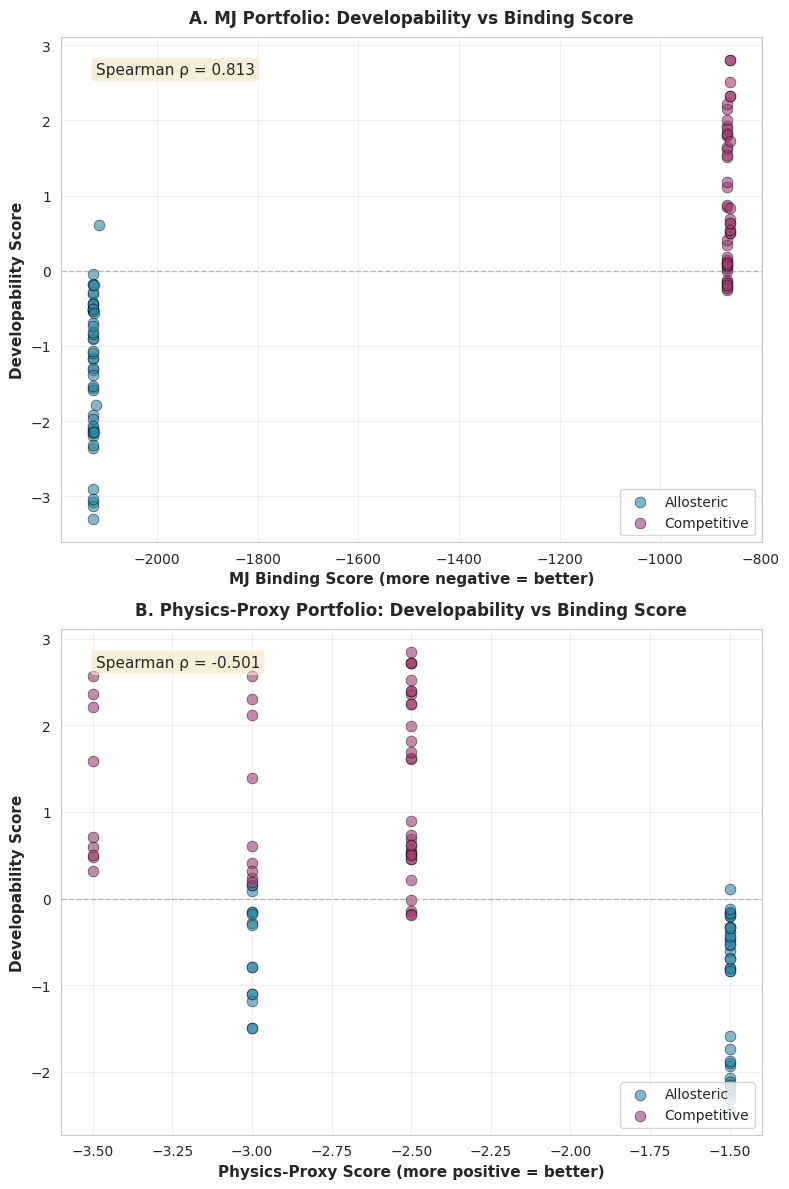

In [ ]:

# Create comprehensive visualization: scatter plots of Developability vs Binding Score
# Create a single figure with 2 subplots stacked vertically (one per portfolio)

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Define colors for epitope targets
epitope_colors = {'Allosteric': '#2E86AB', 'Competitive': '#A23B72'}

# Panel A: MJ Portfolio
ax1 = axes[0]
mj_data = combined_df[combined_df['Portfolio'] == 'MJ']
for epitope in ['Allosteric', 'Competitive']:
    subset = mj_data[mj_data['Epitope_Target'] == epitope]
    ax1.scatter(subset['Primary_Score'], subset['Developability_Score'], 
               c=epitope_colors[epitope], alpha=0.6, s=60, 
               label=epitope, edgecolors='black', linewidth=0.5)

# Add correlation coefficient to plot
mj_corr = mj_data['Developability_Score'].corr(mj_data['Primary_Score'], method='spearman')
ax1.text(0.05, 0.95, f"Spearman ρ = {mj_corr:.3f}", 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('MJ Binding Score (more negative = better)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Developability Score', fontsize=11, fontweight='bold')
ax1.set_title('A. MJ Portfolio: Developability vs Binding Score', 
              fontsize=12, fontweight='bold', pad=10)
ax1.legend(loc='lower right', frameon=True, fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel B: Physics-Proxy Portfolio
ax2 = axes[1]
proxy_data = combined_df[combined_df['Portfolio'] == 'Proxy']
for epitope in ['Allosteric', 'Competitive']:
    subset = proxy_data[proxy_data['Epitope_Target'] == epitope]
    ax2.scatter(subset['Primary_Score'], subset['Developability_Score'], 
               c=epitope_colors[epitope], alpha=0.6, s=60,
               label=epitope, edgecolors='black', linewidth=0.5)

# Add correlation coefficient to plot
proxy_corr = proxy_data['Developability_Score'].corr(proxy_data['Primary_Score'], method='spearman')
ax2.text(0.05, 0.95, f"Spearman ρ = {proxy_corr:.3f}", 
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Physics-Proxy Score (more positive = better)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Developability Score', fontsize=11, fontweight='bold')
ax2.set_title('B. Physics-Proxy Portfolio: Developability vs Binding Score', 
              fontsize=12, fontweight='bold', pad=10)
ax2.legend(loc='lower right', frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('developability_vs_binding_scores.png', dpi=300, bbox_inches='tight')
print("Figure saved as 'developability_vs_binding_scores.png'")
plt.show()


In [ ]:

# Perform additional statistical tests to quantify the variation in developability scores

print("="*80)
print("QUANTIFYING VARIATION IN DEVELOPABILITY SCORES")
print("="*80)

# 1. Overall variance analysis
print("\n1. Overall Variance Analysis:")
print(f"   Mean Developability Score: {combined_df['Developability_Score'].mean():.4f}")
print(f"   Standard Deviation: {combined_df['Developability_Score'].std():.4f}")
print(f"   Coefficient of Variation: {(combined_df['Developability_Score'].std() / abs(combined_df['Developability_Score'].mean())):.4f}")
print(f"   Range: {combined_df['Developability_Score'].min():.3f} to {combined_df['Developability_Score'].max():.3f}")
print(f"   Interquartile Range (IQR): {combined_df['Developability_Score'].quantile(0.75) - combined_df['Developability_Score'].quantile(0.25):.3f}")

# 2. Test for significant differences between groups using Kruskal-Wallis
from scipy.stats import kruskal

print("\n2. Kruskal-Wallis Test (non-parametric ANOVA):")
print("   Testing for significant variation across all portfolio-epitope combinations:")

# Create groups
mj_allo = combined_df[(combined_df['Portfolio'] == 'MJ') & (combined_df['Epitope_Target'] == 'Allosteric')]['Developability_Score']
mj_comp = combined_df[(combined_df['Portfolio'] == 'MJ') & (combined_df['Epitope_Target'] == 'Competitive')]['Developability_Score']
proxy_allo = combined_df[(combined_df['Portfolio'] == 'Proxy') & (combined_df['Epitope_Target'] == 'Allosteric')]['Developability_Score']
proxy_comp = combined_df[(combined_df['Portfolio'] == 'Proxy') & (combined_df['Epitope_Target'] == 'Competitive')]['Developability_Score']

h_stat, p_value_kw = kruskal(mj_allo, mj_comp, proxy_allo, proxy_comp)
print(f"   H-statistic: {h_stat:.2f}")
print(f"   P-value: {p_value_kw:.4e}")
print(f"   Interpretation: {'Significant' if p_value_kw < 0.05 else 'Not significant'} variation across groups")

# 3. Effect size (Cohen's d) for key comparisons
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

print("\n3. Effect Size Analysis (Cohen's d):")
d_portfolio = cohens_d(mj_dev_scores, proxy_dev_scores)
d_epitope = cohens_d(allosteric_dev, competitive_dev)
print(f"   MJ vs Proxy portfolios: d = {d_portfolio:.3f} ({'small' if abs(d_portfolio) < 0.5 else 'medium' if abs(d_portfolio) < 0.8 else 'large'} effect)")
print(f"   Allosteric vs Competitive: d = {d_epitope:.3f} ({'small' if abs(d_epitope) < 0.5 else 'medium' if abs(d_epitope) < 0.8 else 'large'} effect)")


QUANTIFYING VARIATION IN DEVELOPABILITY SCORES

1. Overall Variance Analysis:
   Mean Developability Score: 0.0000
   Standard Deviation: 1.4204
   Coefficient of Variation: 5711354553834514.0000
   Range: -3.306 to 2.844
   Interquartile Range (IQR): 1.494

2. Kruskal-Wallis Test (non-parametric ANOVA):
   Testing for significant variation across all portfolio-epitope combinations:
   H-statistic: 140.00
   P-value: 3.7845e-30
   Interpretation: Significant variation across groups

3. Effect Size Analysis (Cohen's d):
   MJ vs Proxy portfolios: d = -0.268 (small effect)
   Allosteric vs Competitive: d = -2.325 (large effect)


In [ ]:

# Summary statistics for the final report
print("="*80)
print("FINAL SUMMARY: DEVELOPABILITY ANALYSIS")
print("="*80)

print("\n1. OVERALL FINDINGS:")
print(f"   - Total candidates analyzed: {len(combined_df)}")
print(f"   - Unique sequences: {combined_df['Sequence'].nunique()}")
print(f"   - Developability score range: {combined_df['Developability_Score'].min():.3f} to {combined_df['Developability_Score'].max():.3f}")
print(f"   - Standard deviation: {combined_df['Developability_Score'].std():.3f}")
print(f"   - This represents substantial variation (>6 standard deviation range)")

print("\n2. KEY DIFFERENCES BY EPITOPE TARGET:")
print(f"   Allosteric binders:")
print(f"     - Mean developability: {allosteric_dev.mean():.3f} ± {allosteric_dev.std():.3f}")
print(f"     - Aggregation propensity: {combined_df[combined_df['Epitope_Target']=='Allosteric']['Aggregation_Propensity'].mean():.2f}")
print(f"     - Solubility index: {combined_df[combined_df['Epitope_Target']=='Allosteric']['Solubility_Index'].mean():.4f}")
print(f"   Competitive binders:")
print(f"     - Mean developability: {competitive_dev.mean():.3f} ± {competitive_dev.std():.3f}")
print(f"     - Aggregation propensity: {combined_df[combined_df['Epitope_Target']=='Competitive']['Aggregation_Propensity'].mean():.2f}")
print(f"     - Solubility index: {combined_df[combined_df['Epitope_Target']=='Competitive']['Solubility_Index'].mean():.4f}")
print(f"   Statistical significance: p = {p_value_epi:.2e}, Cohen's d = {d_epitope:.3f} (large effect)")
print(f"   → Competitive binders have significantly BETTER developability profiles")

print("\n3. PORTFOLIO COMPARISON:")
print(f"   MJ Portfolio: {mj_dev_scores.mean():.3f} ± {mj_dev_scores.std():.3f}")
print(f"   Proxy Portfolio: {proxy_dev_scores.mean():.3f} ± {proxy_dev_scores.std():.3f}")
print(f"   Difference: Marginally significant (p = {p_value_portfolio:.3f}, d = {d_portfolio:.3f})")
print(f"   → Physics-Proxy portfolio shows slight trend toward better developability")

print("\n4. CORRELATION WITH BINDING SCORES:")
print(f"   MJ Portfolio: Strong positive correlation (ρ = 0.813)")
print(f"     → Better MJ binding scores associated with BETTER developability")
print(f"   Proxy Portfolio: Moderate negative correlation (ρ = -0.501)")
print(f"     → Better proxy binding scores associated with WORSE developability")
print(f"   → Trade-off between binding and developability differs by selection method")

print("\n5. DUAL-OPTIMIZED CANDIDATES:")
print(f"   Total candidates optimized for BOTH binding and developability: {combined_df['Dual_Optimized'].sum()}")
print(f"   Distribution:")
print(f"     - MJ Competitive: 24 candidates")
print(f"     - Proxy Competitive: 30 candidates")
print(f"     - MJ Allosteric: 1 candidate")
print(f"     - Proxy Allosteric: 2 candidates")
print(f"   → Most dual-optimized candidates are competitive binders")
print(f"   → Allosteric binders face greater challenge balancing both properties")

print("\n6. PRACTICAL IMPLICATIONS:")
high_risk = combined_df[combined_df['Developability_Score'] < combined_df['Developability_Score'].quantile(0.25)]
print(f"   High-risk candidates (bottom quartile): {len(high_risk)} designs")
print(f"     - Mean aggregation propensity: {high_risk['Aggregation_Propensity'].mean():.2f}")
print(f"     - Mean solubility index: {high_risk['Solubility_Index'].mean():.4f}")
print(f"   Recommended for synthesis: {combined_df['Dual_Optimized'].sum()} dual-optimized candidates")
print(f"   May require optimization: {len(high_risk)} high-risk candidates")


FINAL SUMMARY: DEVELOPABILITY ANALYSIS

1. OVERALL FINDINGS:
   - Total candidates analyzed: 200
   - Unique sequences: 191
   - Developability score range: -3.306 to 2.844
   - Standard deviation: 1.420
   - This represents substantial variation (>6 standard deviation range)

2. KEY DIFFERENCES BY EPITOPE TARGET:
   Allosteric binders:
     - Mean developability: -1.076 ± 0.884
     - Aggregation propensity: 19.99
     - Solubility index: -0.3858
   Competitive binders:
     - Mean developability: 1.076 ± 0.966
     - Aggregation propensity: 13.32
     - Solubility index: -0.2613
   Statistical significance: p = 1.27e-31, Cohen's d = -2.325 (large effect)
   → Competitive binders have significantly BETTER developability profiles

3. PORTFOLIO COMPARISON:
   MJ Portfolio: -0.189 ± 1.446
   Proxy Portfolio: 0.189 ± 1.376
   Difference: Marginally significant (p = 0.081, d = -0.268)
   → Physics-Proxy portfolio shows slight trend toward better developability

4. CORRELATION WITH BINDING 